In [ ]:
!pip install --quiet pygraphviz pickleshare

In [1]:
%cd ..

/data/home/eak/learning/nganga_ai/tumkwe-invest/tumkwe-invest


In [2]:
from typing import Annotated
from IPython.display import display, Image

from langchain_ollama import ChatOllama  # type: ignore
from langgraph.graph import END, START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph_agentflow.single_step import stream_agent_responses
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from tumkwe_invest import tools
memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]


In [3]:
graph_builder = StateGraph(State)

# Initialize LLM
llm = ChatOllama(model="llama3.3", temperature=0.7)


llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)

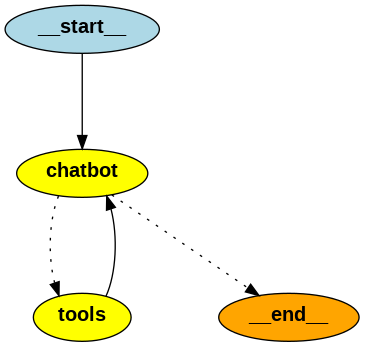

In [4]:
# %% Visualize the Graph (Optional)
try:
	img_data = graph.get_graph().draw_png()
	display(Image(img_data))
except Exception as e:
	# This requires some extra dependencies (like graphviz) and is optional
	print(f"Graph visualization failed (requires graphviz): {e}")
	pass

In [5]:
config = {"configurable": {"thread_id": "user-thread-1"}}
flag = True
while flag:
    try:
        user_input = input("Enter your query (or 'exit' to quit): ")
        if user_input.lower() in ["exit", "quit", "q"]:
            flag = False
            break

        # Stream the agent's response
        for step in stream_agent_responses(graph, user_input, config):
            message = step["messages"][-1]
            message.pretty_print()
    except Exception as e:
        print(f"An error occurred: {e}")

================================ Human Message =================================

What’s the current stock price of Apple
================================== Ai Message ==================================
Tool Calls:
  get_stock_info (cb4a6bbd-ee9b-418b-bff6-7d131c403fa1)
 Call ID: cb4a6bbd-ee9b-418b-bff6-7d131c403fa1
  Args:
    ticker: AAPL
================================= Tool Message =================================
Name: get_stock_info

{"address1": "One Apple Park Way", "city": "Cupertino", "state": "CA", "zip": "95014", "country": "United States", "phone": "(408) 996-1010", "website": "https://www.apple.com", "industry": "Consumer Electronics", "industryKey": "consumer-electronics", "industryDisp": "Consumer Electronics", "sector": "Technology", "sectorKey": "technology", "sectorDisp": "Technology", "longBusinessSummary": "Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a lin